<a href="https://colab.research.google.com/github/ZaharZh/AI_Hedgehog/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек


In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os

import torch
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import torch.nn as nn
from tqdm.notebook import tqdm
from torchsummary import summary
from PIL import Image

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json  ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download   "drscarlat/melanoma"

100% 5.26G/5.26G [01:45<00:00, 42.3MB/s]
100% 5.26G/5.26G [01:45<00:00, 53.7MB/s]


In [4]:
! unzip -q "/content/melanoma.zip"

# 1. Загрузка данных

In [5]:
data_image_train='/content/DermMel/train_sep'
data_image_test='/content/DermMel/test'
data_image_valid='/content/DermMel/valid'

In [6]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [7]:
train = datasets.ImageFolder(data_image_train, transform=resnet_transforms)
test = datasets.ImageFolder(data_image_test, transform=resnet_transforms)
valid = datasets.ImageFolder(data_image_valid, transform=resnet_transforms)

In [8]:
data_train = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
data_test = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)
data_valid = torch.utils.data.DataLoader(valid, batch_size=32, shuffle=False)

In [9]:
for batch in data_train:
    break

batch[0].shape, batch[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# 2. Пример данных

In [10]:
dataiter = iter(data_train)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


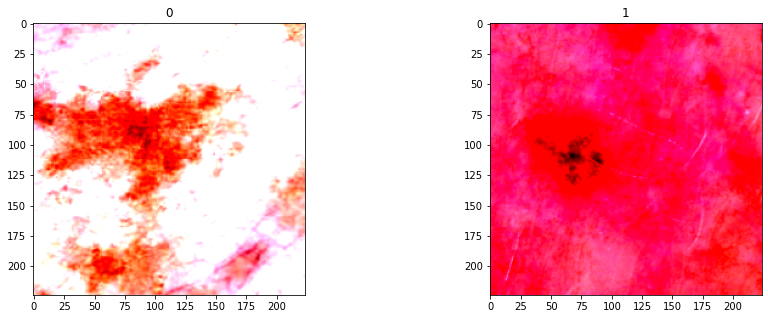

In [11]:
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 2, figsize=(15, 5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

# 3. Функция обучения


In [12]:
def train(model, n_epoch=6):
    loss_fn = torch.nn.CrossEntropyLoss()

    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in tqdm(range(n_epoch)):
        train_dataiter = iter(data_train)
        running_loss = 0.0

        model.train(True)
        for i, batch in enumerate(tqdm(train_dataiter)):
            X_batch, y_batch = batch
            
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device)) 
            loss.backward() 
            optimizer.step() 
            optimizer.zero_grad() 
            running_loss += loss.detach().cpu().item()

            if i % 50 == 49:
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 49))
                train_losses.append(running_loss / 49)
                running_loss = 0.0

        model.train(False)
        val_dataiter = iter(data_valid)


        val_loss_per_epoch = 0
        val_accuracy_per_epoch = 0
        for i, batch in enumerate(tqdm(val_dataiter)):
            X_batch, y_batch = batch
            with torch.no_grad():
                logits = model(X_batch)
                y_pred = torch.argmax(logits, dim=1)
                val_accuracy_per_epoch += np.mean(y_pred.numpy() == y_batch.numpy())

                val_loss_per_epoch += loss_fn(logits, y_batch)

        val_accuracies.append(val_accuracy_per_epoch / (i + 1))
        val_losses.append(val_loss_per_epoch / (i + 1))

    print('Обучение закончено')
    return model, train_losses, val_losses, val_accuracies

# 4. Посторение модели


In [ ]:
  class ConvNet(nn.Module): # Модель которую мы написали, но потребляющая много памяти
      def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,kernel_size=(7,7))
        nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(6,6), padding='same')
        nn.ReLU()
        self.bn0 = nn.BatchNorm2d(32)
        self.mpool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(6,6),padding='same')
        nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(5,5), padding='same')
        nn.ReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.apool = nn.AvgPool2d(kernel_size=(2, 2))
        self.conv5 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(5,5), padding='same')
        nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(5,5), padding='same')
        nn.ReLU()
        self.bn2 = nn.BatchNorm2d(128)
        self.apool2 = nn.AvgPool2d(kernel_size=(2, 2))
        self.conv7 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),padding='same')
        nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(4,4), padding='same')
        nn.ReLU()
        self.bn3 = nn.BatchNorm2d(256)
        self.mpool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=512,kernel_size=(3,3),padding='same')
        nn.ReLU()
        self.conv10 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),padding='valid')
        nn.ReLU()
        self.bn4 = nn.BatchNorm2d(512)
        self.flatten1 = nn.Flatten()
        self.fc1 = nn.Linear(100 * 100 * 256, 256)
        nn.Sigmoid()
        self.fc2 = nn.Linear(256, 2)
      def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn0(x)
        x = self.mpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn1(x) 
        x = self.apool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.bn2(x)
        x = self.apool2(x)
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.bn3(x)
        x = self.mpool2
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.bn4(x)
        x = self.flatten1(x)
        x = torch.sigmoid(self.fc1(x))
        x  = self.fc2(x)
          
        return x

In [ ]:
class ConvNet(nn.Module): # модель которую мы взяли у Юрия
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(7,7))
        nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(5,5))
        nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3))
        self.pool = nn.MaxPool2d(kernel_size=(2,2)) 
        nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3))
        self.bn1 = nn.BatchNorm2d(128)
        nn.ReLU()
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)) 
        nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3)) 
        nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(100 * 100 * 256, 256)
        nn.Sigmoid()
        self.fc2 = nn.Linear(256, 2)

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.bn1(x) 
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))

        x  = self.fc2(x)
        
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

conv_net = ConvNet().to(device)
conv_net

ConvNet(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2560000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

In [ ]:
data_train

In [ ]:
for batch in data_train:
    break

batch[0].shape, batch[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
conv_net, train_losses_conv, val_lossesmodel_conv, val_accuracies_conv = train(conv_net, n_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

In [20]:
model=models.resnet18(pretrained=False)
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

In [21]:
model, train_losses_conv, val_lossesmodel_conv, val_accuracies_conv = train(model, n_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,    50] loss: 0.999
[1,   100] loss: 0.481
[1,   150] loss: 0.460
[1,   200] loss: 0.435
[1,   250] loss: 0.434
[1,   300] loss: 0.400


  0%|          | 0/112 [00:00<?, ?it/s]

Обучение закончено


In [22]:
model, train_losses_conv, val_lossesmodel_conv, val_accuracies_conv = train(model, n_epoch=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

[1,    50] loss: 0.440
[1,   100] loss: 0.399
[1,   150] loss: 0.427
[1,   200] loss: 0.378
[1,   250] loss: 0.387
[1,   300] loss: 0.370


  0%|          | 0/112 [00:00<?, ?it/s]

Обучение закончено


In [ ]:
torch.save(model.state_dict(), os.path.join('/content',"melanoma"))

In [26]:
torch.save(model.state_dict(), os.path.join('/content',"melanoma"))